In [1]:
import sys
sys.path.append("..")
%cd ..

/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/DTU/6. Semester/Bachelor2021


In [2]:
from DataPrep.load_data import load_data
from Modelling import modelling
import keras
from keras import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input, Reshape
import pyforest
import torch
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error


In [3]:
df = load_data()
df = df.drop(columns=["Charging Time (mins)", "Parking Time (mins)"])


In [5]:
temporal_cols = ['Energy (kWh)', 'Fee (USD)', 'Month_Day_1', 'Month_Day_2', 'Month_Day_3', 'Month_Day_4',
       'Month_Day_5', 'Month_Day_6', 'Month_Day_7', 'Month_Day_8',
       'Month_Day_9', 'Month_Day_10', 'Month_Day_11', 'Month_Day_12',
       'Month_Day_13', 'Month_Day_14', 'Month_Day_15', 'Month_Day_16',
       'Month_Day_17', 'Month_Day_18', 'Month_Day_19', 'Month_Day_20',
       'Month_Day_21', 'Month_Day_22', 'Month_Day_23', 'Month_Day_24',
       'Month_Day_25', 'Month_Day_26', 'Month_Day_27', 'Month_Day_28',
       'Month_Day_29', 'Month_Day_30', 'Month_Day_31', 'Week_Day_0',
       'Week_Day_1', 'Week_Day_2', 'Week_Day_3', 'Week_Day_4', 'Week_Day_5',
       'Week_Day_6', 'Year_Month_1', 'Year_Month_2', 'Year_Month_3',
       'Year_Month_4', 'Year_Month_5', 'Year_Month_6', 'Year_Month_7',
       'Year_Month_8', 'Year_Month_9', 'Year_Month_10', 'Year_Month_11',
       'Year_Month_12']
       
spacial_cols = ['Label','# Professional & Other Places',
       '# Food', '# Shop & Service', '# Travel & Transport',
       '# Outdoors & Recreation', '# Arts & Entertainment', '# Nightlife Spot',
       '# Residence', '# College & University', '# Event', 'Plugs', 'Label_0',
       'Label_1', 'Label_2', 'Label_3', 'Label_4', 'Label_5', 'Label_6',
       'Label_7']

In [7]:
df.head()

,Label,Energy (kWh),Fee (USD),# Professional & Other Places,# Food,# Shop & Service,# Travel & Transport,# Outdoors & Recreation,# Arts & Entertainment,# Nightlife Spot,...,Year_Month_3,Year_Month_4,Year_Month_5,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12
Date,,,,,,,,,,,,,,,,,,,,,
2011-07-29,0,6.249457,0.0,284,272,230,218.0,174,129,121.0,...,0,0,0,0,1,0,0,0,0,0
2011-07-30,0,28.978653,0.0,284,272,230,218.0,174,129,121.0,...,0,0,0,0,1,0,0,0,0,0
2011-07-31,0,37.209163,0.0,284,272,230,218.0,174,129,121.0,...,0,0,0,0,1,0,0,0,0,0
2011-08-01,0,5.041244,0.0,284,272,230,218.0,174,129,121.0,...,0,0,0,0,0,1,0,0,0,0
2011-08-02,0,16.210423,0.0,284,272,230,218.0,174,129,121.0,...,0,0,0,0,0,1,0,0,0,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

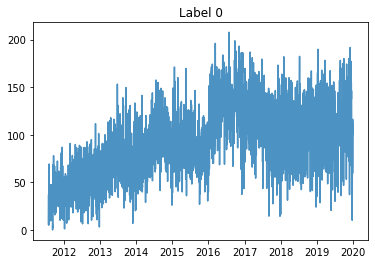

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

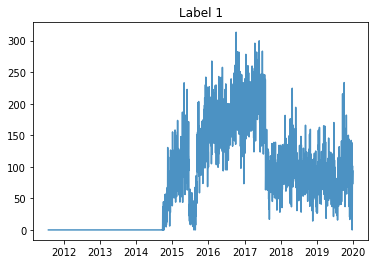

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

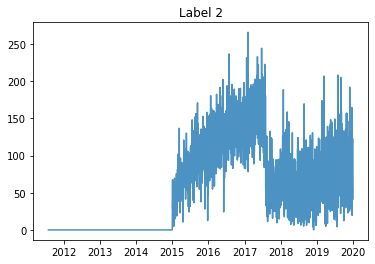

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

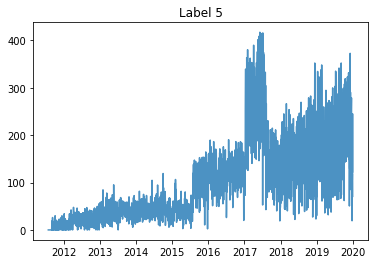

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

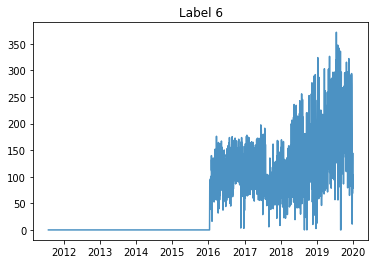

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

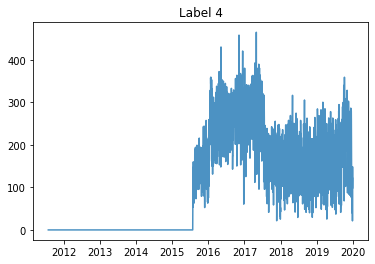

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

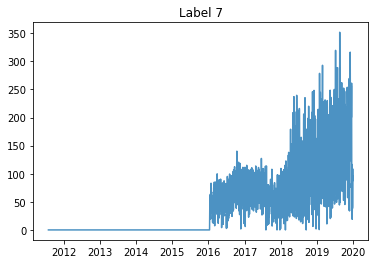

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

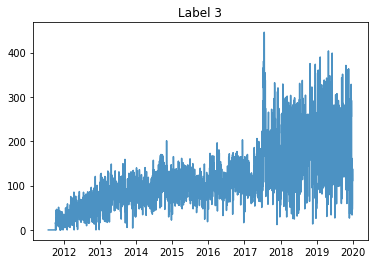

In [8]:
for l in df.Label.unique():
    
    plt.plot(df.index[df.Label == l],df["Energy (kWh)"][df.Label == l], alpha = 0.8)
    plt.title(f"Label {l}")
    plt.show()

In [9]:
cols_to_standardize = ['# Professional & Other Places', '# Food', '# Shop & Service',
       '# Travel & Transport', '# Outdoors & Recreation',
       '# Arts & Entertainment', '# Nightlife Spot', '# Residence',
       '# College & University', '# Event']

sc = StandardScaler()
stand_poi = sc.fit_transform(df[cols_to_standardize])
stand_poi = pd.DataFrame(stand_poi, index=df.index, columns=cols_to_standardize)
for i in cols_to_standardize:
    df[i] = stand_poi[i]

<IPython.core.display.Javascript object>

In [10]:
df = df.fillna(0)

In [9]:
df.head()

,Label,Energy (kWh),Fee (USD),# Professional & Other Places,# Food,# Shop & Service,# Travel & Transport,# Outdoors & Recreation,# Arts & Entertainment,# Nightlife Spot,...,Year_Month_4,Year_Month_5,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,Holiday
Date,,,,,,,,,,,,,,,,,,,,,
2011-07-29,0,6.249457,0.0,0.783416,1.062843,0.750792,1.152355,1.377951,1.119321,0.712468,...,0,0,0,1,0,0,0,0,0,0
2011-07-30,0,28.978653,0.0,0.783416,1.062843,0.750792,1.152355,1.377951,1.119321,0.712468,...,0,0,0,1,0,0,0,0,0,0
2011-07-31,0,37.209163,0.0,0.783416,1.062843,0.750792,1.152355,1.377951,1.119321,0.712468,...,0,0,0,1,0,0,0,0,0,0
2011-08-01,0,5.041244,0.0,0.783416,1.062843,0.750792,1.152355,1.377951,1.119321,0.712468,...,0,0,0,0,1,0,0,0,0,0
2011-08-02,0,16.210423,0.0,0.783416,1.062843,0.750792,1.152355,1.377951,1.119321,0.712468,...,0,0,0,0,1,0,0,0,0,0


In [12]:
def standardize(v):
    return (v - v.mean())/v.std()

In [14]:
df["Energy (kWh)"] = standardize(df["Energy (kWh)"])

     


In [16]:
df = df.sort_index()

In [17]:
df = df[df.Label == 0]

In [60]:
def create_data(X,y, pred_len, time_slot):
    Xs, ys = [], []
    for i in range(int(len(X) - pred_len - time_slot + 1)):
        X_start = i
        X_end = X_start + time_slot


        y_start = X_end
        y_end = y_start + pred_len

        v = X.iloc[X_start:X_end].values
        Xs.append(v)

        ys.append(y[y_start:y_end])
    return np.array(Xs), np.array(ys)


In [248]:
X = df[temporal_cols]
y = df["Energy (kWh)"]

In [249]:
X, y = create_data(X,y, 7, 30)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [235]:
X.shape

(3042, 30, 52)

In [236]:
y.shape

(3042, 7)

In [65]:
X.shape

(3042, 30, 52)

In [67]:
3042*0.1

304.2

In [70]:
split = [2433, 204 ,405]

In [250]:
X_train, X_val, X_test = tf.split(X, split)

<IPython.core.display.Javascript object>

In [251]:
y_train, y_val, y_test = tf.split(y, split)

<IPython.core.display.Javascript object>

In [73]:
from keras import backend

In [240]:
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [255]:
inputs = Input(shape=(None,52))
x = LSTM(35, return_sequences = False, activation = "tanh")(inputs)
outputs = Dense(7)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_model")
#opt = keras.optimizers.Adam(learning_rate=1*10**(-4))
model.compile(optimizer="Adam", loss='mse', metrics=[rmse])


In [253]:
model.summary()

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, 52)]        0         
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 35)          12320     
_________________________________________________________________
dense_6 (Dense)              (None, None, 7)           252       
Total params: 12,572
Trainable params: 12,572
Non-trainable params: 0
_________________________________________________________________


In [45]:
y_train.shape

TensorShape([303, 49])

In [257]:

history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data = (X_val, y_val))

Epoch 1/20
153/153 [==============================] - 2s 10ms/step - loss: 0.0570 - rmse: 0.2266 - val_loss: 0.1078 - val_rmse: 0.3143
Epoch 2/20
153/153 [==============================] - 1s 9ms/step - loss: 0.0570 - rmse: 0.2265 - val_loss: 0.1083 - val_rmse: 0.3150
Epoch 3/20
153/153 [==============================] - 1s 10ms/step - loss: 0.0560 - rmse: 0.2247 - val_loss: 0.1193 - val_rmse: 0.3288
Epoch 4/20
153/153 [==============================] - 1s 9ms/step - loss: 0.0553 - rmse: 0.2234 - val_loss: 0.1134 - val_rmse: 0.3214
Epoch 5/20
153/153 [==============================] - 1s 9ms/step - loss: 0.0549 - rmse: 0.2224 - val_loss: 0.1143 - val_rmse: 0.3222
Epoch 6/20
153/153 [==============================] - 1s 9ms/step - loss: 0.0541 - rmse: 0.2209 - val_loss: 0.1129 - val_rmse: 0.3208
Epoch 7/20
153/153 [==============================] - 2s 10ms/step - loss: 0.0537 - rmse: 0.2203 - val_loss: 0.1177 - val_rmse: 0.3267
Epoch 8/20
153/153 [==============================] - 1s 9m

In [85]:
X_val.shape

TensorShape([204, 30, 52])

In [145]:
preds = model.predict(np.array(X_val[0]).reshape(1,30,52))

<IPython.core.display.Javascript object>

In [99]:
y_val.shape

TensorShape([204, 7])

In [107]:
preds.shape

(1428,)

In [149]:
y_val.shape

TensorShape([204, 7])

array([[ 0.5534328 ,  0.48469558, -0.08129977, ...,  0.35154748,
         0.49360815,  0.53097606],
       [ 0.46171024, -0.07422116,  0.00513519, ...,  0.49278313,
         0.44397524,  0.49195915],
       [-0.05299227, -0.04613505,  0.38588893, ...,  0.5014685 ,
         0.5550546 ,  0.36025774],
       ...,
       [ 0.40516588,  0.40520987,  0.40383768, ...,  0.09690048,
         0.08227427,  0.35065675],
       [ 0.5422111 ,  0.43722066,  0.41189727, ..., -0.05800451,
         0.47667938,  0.6133366 ],
       [ 0.3790811 ,  0.4443135 ,  0.03143152, ...,  0.32044488,
         0.6414848 ,  0.52137655]], dtype=float32)

In [146]:
for i in range(1,204):
    preds = np.hstack((preds,model.predict(np.array(X_val[i]).reshape(1,30,52))))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [167]:
preds = preds.reshape(204,7)

In [165]:
np.sqrt(mean_squared_error(np.array(y_val).flatten(),preds.flatten()))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.308054726344862

In [229]:
preds

array([[ 0.5534328 ,  0.48469558, -0.08129977, ...,  0.35154748,
         0.49360815,  0.53097606],
       [ 0.46171024, -0.07422116,  0.00513519, ...,  0.49278313,
         0.44397524,  0.49195915],
       [-0.05299227, -0.04613505,  0.38588893, ...,  0.5014685 ,
         0.5550546 ,  0.36025774],
       ...,
       [ 0.40516588,  0.40520987,  0.40383768, ...,  0.09690048,
         0.08227427,  0.35065675],
       [ 0.5422111 ,  0.43722066,  0.41189727, ..., -0.05800451,
         0.47667938,  0.6133366 ],
       [ 0.3790811 ,  0.4443135 ,  0.03143152, ...,  0.32044488,
         0.6414848 ,  0.52137655]], dtype=float32)

In [204]:
preds_flat = preds[:,0]

<IPython.core.display.Javascript object>

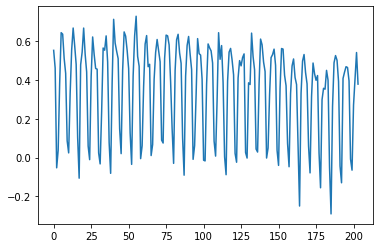

In [230]:
plt.plot(preds_flat)

In [188]:
X_spacial = df[spacial_cols]
y = df["Energy (kWh)"]

In [189]:
X_spacial, y = create_data(X_spacial,y, 7, 30)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [190]:
X_train_sp, X_val_sp, X_test_sp = tf.split(X, split)

<IPython.core.display.Javascript object>

In [194]:
X_val.shape

TensorShape([204, 30, 52])

In [228]:
preds_tensor = []
for i in range(preds_flat.shape[0]-30):
    preds_tensor.append(preds_flat[i:i+30])

tf.convert_to_tensor(preds_tensor)

<IPython.core.display.Javascript object>

<tf.Tensor: shape=(174, 30), dtype=float32, numpy=
array([[ 0.5534328 ,  0.46171024, -0.05299227, ...,  0.5325572 ,
         0.45990437,  0.45624143],
       [ 0.46171024, -0.05299227,  0.03798631, ...,  0.45990437,
         0.45624143,  0.02359739],
       [-0.05299227,  0.03798631,  0.38250652, ...,  0.45624143,
         0.02359739, -0.03280809],
       ...,
       [-0.07921652,  0.3149769 ,  0.48798674, ..., -0.00801481,
        -0.06504318,  0.2707052 ],
       [ 0.3149769 ,  0.48798674,  0.43290985, ..., -0.06504318,
         0.2707052 ,  0.40516588],
       [ 0.48798674,  0.43290985,  0.3989439 , ...,  0.2707052 ,
         0.40516588,  0.5422111 ]], dtype=float32)>

In [166]:
inputs = Input(shape=(None,7))
x = Dense(20,  activation = "relu")(inputs)
x = Dropout(0.5)(x)
x = Dense(10, return_sequences = False, activation = "tanh")(inputs)
outputs = Dense(7)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="ANN")
#opt = keras.optimizers.Adam(learning_rate=1*10**(-4))
model.compile(optimizer="Adam", loss='mse', metrics=[rmse])

array([[ 0.5534328 ,  0.48469558, -0.08129977, ...,  0.35154748,
         0.49360815,  0.53097606],
       [ 0.46171024, -0.07422116,  0.00513519, ...,  0.49278313,
         0.44397524,  0.49195915],
       [-0.05299227, -0.04613505,  0.38588893, ...,  0.5014685 ,
         0.5550546 ,  0.36025774],
       ...,
       [ 0.40516588,  0.40520987,  0.40383768, ...,  0.09690048,
         0.08227427,  0.35065675],
       [ 0.5422111 ,  0.43722066,  0.41189727, ..., -0.05800451,
         0.47667938,  0.6133366 ],
       [ 0.3790811 ,  0.4443135 ,  0.03143152, ...,  0.32044488,
         0.6414848 ,  0.52137655]], dtype=float32)

<IPython.core.display.Javascript object>

array([0.6700223 , 0.2857608 , 0.36622792, 0.96946204, 1.0855503 ,
       1.1336557 , 0.87808144, 0.58773834, 0.04028369, 0.24496472,
       1.0315033 , 1.1114626 , 0.9449649 , 0.7933438 , 0.38044855,
       0.29879785, 0.4405336 , 0.88252145, 1.0528129 , 1.0412726 ,
       0.7542023 , 0.6263537 , 0.18153411, 0.43996075, 0.972934  ,
       1.2144918 , 1.0961479 , 1.1233789 , 0.6456466 , 0.20351437,
       0.33359808, 0.57188207, 1.0368563 , 1.2424861 , 0.8021971 ,
       0.50908095, 0.11874899, 0.35400084, 0.6312554 , 1.0807918 ,
       0.94054157, 0.8600965 , 0.40124014, 0.280579  , 0.2894798 ,
       0.6445318 , 0.9425032 , 0.8512564 , 0.7853371 ], dtype=float32)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

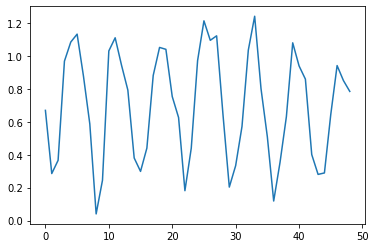

In [152]:
model.predict(np.array(X_val[0]).reshape(1,210,72))

<IPython.core.display.Javascript object>

array([[0.6700223 , 0.2857608 , 0.36622792, 0.96946204, 1.0855503 ,
        1.1336557 , 0.87808144, 0.58773834, 0.04028369, 0.24496472,
        1.0315033 , 1.1114626 , 0.9449649 , 0.7933438 , 0.38044855,
        0.29879785, 0.4405336 , 0.88252145, 1.0528129 , 1.0412726 ,
        0.7542023 , 0.6263537 , 0.18153411, 0.43996075, 0.972934  ,
        1.2144918 , 1.0961479 , 1.1233789 , 0.6456466 , 0.20351437,
        0.33359808, 0.57188207, 1.0368563 , 1.2424861 , 0.8021971 ,
        0.50908095, 0.11874899, 0.35400084, 0.6312554 , 1.0807918 ,
        0.94054157, 0.8600965 , 0.40124014, 0.280579  , 0.2894798 ,
        0.6445318 , 0.9425032 , 0.8512564 , 0.7853371 ]], dtype=float32)

In [165]:
model.predict(np.array(X_val[1]).reshape(1,210,72)).flatten()[-7:]

<IPython.core.display.Javascript object>

array([0.3405826 , 0.22352737, 0.1894316 , 0.574728  , 0.87527347,
       0.7892815 , 0.73218155], dtype=float32)

array([0.6700223 , 0.2857608 , 0.36622792, 0.96946204, 1.0855503 ,
       1.1336557 , 0.87808144, 0.58773834, 0.04028369, 0.24496472,
       1.0315033 , 1.1114626 , 0.9449649 , 0.7933438 , 0.38044855,
       0.29879785, 0.4405336 , 0.88252145, 1.0528129 , 1.0412726 ,
       0.7542023 , 0.6263537 , 0.18153411, 0.43996075, 0.972934  ,
       1.2144918 , 1.0961479 , 1.1233789 , 0.6456466 , 0.20351437,
       0.33359808, 0.57188207, 1.0368563 , 1.2424861 , 0.8021971 ,
       0.50908095, 0.11874899, 0.35400084, 0.6312554 , 1.0807918 ,
       0.94054157, 0.8600965 , 0.40124014, 0.280579  , 0.2894798 ,
       0.6445318 , 0.9425032 , 0.8512564 , 0.7853371 ], dtype=float32)

In [173]:
from tqdm import tqdm

TensorShape([384, 49])

<IPython.core.display.Javascript object>

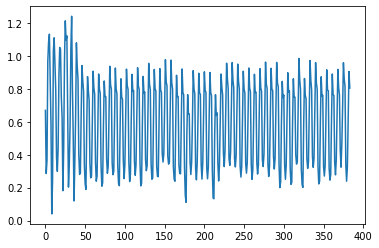

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

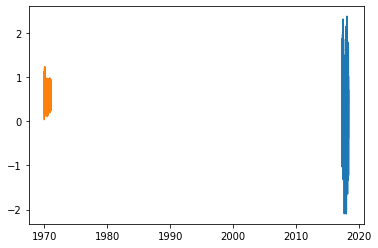

In [186]:
plt.plot(df)

plt.plot(df.ix_val_pred[:384])

In [174]:
x_val_pred = model.predict(np.array(X_val[0]).reshape(1,210,72)).flatten()

with tqdm(total=49) as pbar:
    for i in range(1,X_val.shape[0]):
        pred = model.predict(np.array(X_val[i]).reshape(1,210,72)).flatten()[-7:]
        x_val_pred = np.append(x_val_pred, pred)
        pbar.update(1)


<IPython.core.display.Javascript object>

  0%|          | 0/49 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  4%|▍         | 2/49 [00:00<00:02, 18.22it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  8%|▊         | 4/49 [00:00<00:02, 17.88it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 12%|█▏        | 6/49 [00:00<00:02, 16.78it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 16%|█▋        | 8/49 [00:00<00:02, 16.85it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 20%|██        | 10/49 [00:00<00:02, 16.78it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 24%|██▍       | 12/49 [00:00<00:02, 16.39it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 29%|██▊       | 14/49 [00:00<00:02, 16.64it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 33%|███▎      | 16/49 [00:00<00:02, 16.24it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 37%|███▋      | 18/49 [00:01<00:01, 15.64it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 41%|████      | 20/49 [00:01<00:02, 14.32it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 45%|████▍     | 22/49 [00:01<00:02, 13.08it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 49%|████▉     | 24/49 [00:01<00:02, 12.36it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 53%|█████▎    | 26/49 [00:01<00:01, 12.73it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 57%|█████▋    | 28/49 [00:01<00:01, 12.86it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 61%|██████    | 30/49 [00:02<00:01, 13.46it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 65%|██████▌   | 32/49 [00:02<00:01, 13.70it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 69%|██████▉   | 34/49 [00:02<00:01, 13.28it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 73%|███████▎  | 36/49 [00:02<00:00, 13.45it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 78%|███████▊  | 38/49 [00:02<00:00, 13.42it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 82%|████████▏ | 40/49 [00:02<00:00, 12.73it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 86%|████████▌ | 42/49 [00:02<00:00, 12.86it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 90%|████████▉ | 44/49 [00:03<00:00, 13.15it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 94%|█████████▍| 46/49 [00:03<00:00, 13.84it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 98%|█████████▊| 48/49 [00:03<00:00, 14.59it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

50it [00:03, 14.95it/s]                        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

52it [00:03, 15.14it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

54it [00:03, 15.96it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

56it [00:03, 16.32it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

58it [00:03, 16.85it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

60it [00:04, 16.83it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

62it [00:04, 17.03it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

64it [00:04, 17.08it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

66it [00:04, 17.65it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

68it [00:04, 17.79it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

70it [00:04, 17.58it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

72it [00:04, 17.62it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

74it [00:04, 17.11it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

76it [00:05, 16.69it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

78it [00:05, 17.08it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

81it [00:05, 18.19it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

83it [00:05, 18.04it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

85it [00:05, 18.21it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

87it [00:05, 17.95it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

89it [00:05, 18.32it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

91it [00:05, 18.20it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

93it [00:05, 18.50it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

96it [00:06, 18.65it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

98it [00:06, 18.72it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100it [00:06, 18.64it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

102it [00:06, 18.67it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

104it [00:06, 18.91it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

106it [00:06, 18.55it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

108it [00:06, 18.72it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

110it [00:06, 18.71it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

112it [00:06, 18.93it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

114it [00:07, 18.78it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

116it [00:07, 18.82it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

118it [00:07, 17.77it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

120it [00:07, 17.31it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

122it [00:07, 17.43it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

124it [00:07, 15.86it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

126it [00:07, 16.26it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

128it [00:07, 16.97it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

130it [00:07, 17.37it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

132it [00:08, 17.26it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

134it [00:08, 16.77it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

136it [00:08, 16.30it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

138it [00:08, 16.73it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

140it [00:08, 16.85it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

142it [00:08, 16.34it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

144it [00:08, 16.03it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

146it [00:08, 16.31it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

148it [00:09, 17.00it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

150it [00:09, 17.20it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

152it [00:09, 17.07it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

154it [00:09, 17.75it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

156it [00:09, 17.88it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

159it [00:09, 18.53it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

161it [00:09, 17.88it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

163it [00:09, 16.81it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

165it [00:10, 15.55it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

167it [00:10, 15.41it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

169it [00:10, 15.39it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

171it [00:10, 14.96it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

173it [00:10, 15.55it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

175it [00:10, 15.83it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

177it [00:10, 15.81it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

179it [00:10, 16.31it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

181it [00:11, 15.72it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

183it [00:11, 16.25it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

185it [00:11, 16.43it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

187it [00:11, 16.83it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

189it [00:11, 16.67it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

191it [00:11, 15.08it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

193it [00:11, 14.72it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

195it [00:12, 15.21it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

197it [00:12, 15.87it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

199it [00:12, 16.66it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

201it [00:12, 16.68it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

203it [00:12, 17.15it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

205it [00:12, 16.93it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

207it [00:12, 17.40it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

209it [00:12, 17.55it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

211it [00:12, 16.31it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

213it [00:13, 16.04it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

215it [00:13, 15.81it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

217it [00:13, 15.63it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

219it [00:13, 14.46it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

221it [00:13, 15.00it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

223it [00:13, 14.83it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

225it [00:13, 14.31it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

227it [00:14, 13.69it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

229it [00:14, 13.99it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

231it [00:14, 14.92it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

233it [00:14, 15.29it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

235it [00:14, 16.02it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

237it [00:14, 16.08it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

239it [00:14, 16.33it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

241it [00:14, 16.59it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

243it [00:15, 16.94it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

245it [00:15, 15.94it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

247it [00:15, 16.03it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

249it [00:15, 15.37it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

251it [00:15, 15.67it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

253it [00:15, 14.95it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

255it [00:15, 15.29it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

257it [00:15, 16.30it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

259it [00:16, 16.41it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

261it [00:16, 16.81it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

263it [00:16, 16.86it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

265it [00:16, 17.05it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

267it [00:16, 16.01it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

269it [00:16, 16.10it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

271it [00:16, 16.15it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

273it [00:16, 15.78it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

275it [00:17, 16.19it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

277it [00:17, 16.37it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

279it [00:17, 16.56it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

281it [00:17, 16.22it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

283it [00:17, 16.32it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

285it [00:17, 15.96it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

287it [00:17, 14.78it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

289it [00:17, 15.41it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

291it [00:18, 15.83it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

293it [00:18, 15.30it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

295it [00:18, 13.66it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

297it [00:18, 14.50it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

299it [00:18, 14.28it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

301it [00:18, 14.34it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

303it [00:18, 14.38it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

305it [00:19, 14.39it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

307it [00:19, 14.67it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

309it [00:19, 15.23it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

311it [00:19, 14.80it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

313it [00:19, 14.78it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

315it [00:19, 15.32it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

317it [00:19, 14.73it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

319it [00:19, 14.52it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

321it [00:20, 14.01it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

323it [00:20, 13.95it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

325it [00:20, 13.92it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

327it [00:20, 14.20it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

329it [00:20, 15.02it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

331it [00:20, 15.59it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

333it [00:20, 15.18it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

335it [00:21, 16.03it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

337it [00:21, 16.25it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

339it [00:21, 15.28it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

341it [00:21, 16.13it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

343it [00:21, 16.53it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

345it [00:21, 15.83it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

347it [00:21, 16.02it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

349it [00:21, 16.16it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

351it [00:22, 16.54it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

353it [00:22, 16.89it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

355it [00:22, 17.32it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

357it [00:22, 17.26it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

359it [00:22, 17.38it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

361it [00:22, 17.71it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

363it [00:22, 17.60it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

365it [00:22, 16.31it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

367it [00:22, 15.65it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

369it [00:23, 15.33it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

371it [00:23, 13.39it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

373it [00:23, 11.48it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

375it [00:23, 10.79it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

377it [00:24,  4.91it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

379it [00:24,  6.23it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

381it [00:24,  7.72it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

383it [00:25, 15.29it/s]


In [151]:
np.sqrt(mean_squared_error(y_val[0], model.predict(np.array(X_val[0]).reshape(1,210,72)).flatten()))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.7174279343808242

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

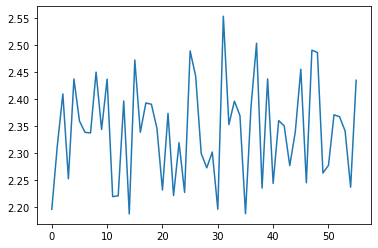

In [161]:

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

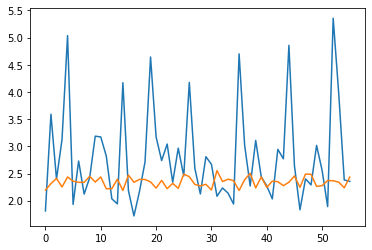

In [163]:
plt.plot(y_val[0])
plt.plot(model.predict(X_val)[0])
plt.show()

In [147]:
X_val[0]

<tf.Tensor: shape=(240, 81), dtype=float64, numpy=
array([[   6.        ,    2.34068723, -122.146     , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    2.78041914, -122.16      , ...,    0.        ,
           0.        ,    0.        ],
       [   5.        ,    3.03460329, -122.158     , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   5.        ,    3.79337143, -122.158     , ...,    0.        ,
           0.        ,    1.        ],
       [   3.        ,    4.81968309, -122.11321931, ...,    0.        ,
           0.        ,    1.        ],
       [   1.        ,    2.44940629, -122.163     , ...,    0.        ,
           0.        ,    1.        ]])>

In [561]:
X_val[0][-1][1]

2.692439024390244

In [580]:
model.predict(np.array(df[-1458:-2]).reshape(1,1456,81))

<IPython.core.display.Javascript object>

array([[2.7247455]], dtype=float32)

In [584]:
X_val.shape

(63, 1456, 81)

In [611]:
float(model.predict(np.array(df[-1458:-2]).reshape(1,1456,81)))

<IPython.core.display.Javascript object>

2.724745512008667

In [612]:
df.iloc[-1]["Energy (kWh)"]

3.383807692307693

In [965]:
def predic():
    preds = []
    for i in range(100):
        pred = float(model.predict(np.array(df[-1358+i:-102+i]).reshape(1,1256,81)))
        preds.append(pred)
    
    return preds

In [967]:
preds = predic()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [968]:
r2_score(np.array(df[-101:-1]["Energy (kWh)"]),np.array(preds))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-4.731077014302545

In [969]:
preds = []
for i in range(X_val.shape[0]):
    pred = model.predict(np.array(X_val[i]).reshape(1,1456,81))
    preds.append(float(pred))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [970]:
preds

[0.5611644983291626,
 0.5701436996459961,
 0.5911750197410583,
 0.5864356756210327,
 0.5948604941368103,
 0.6334630846977234,
 0.5695988535881042,
 0.5648144483566284,
 0.5442633628845215,
 0.4975155293941498,
 0.5873321294784546,
 0.6605113744735718,
 0.5594258308410645,
 0.6802462935447693,
 0.5902557969093323,
 0.6363338828086853,
 0.645184338092804,
 0.6324993371963501,
 0.6544402837753296,
 0.5992485284805298,
 0.5528717041015625,
 0.5810484886169434,
 0.6608498096466064,
 0.6520194411277771,
 0.6644423604011536,
 0.6175932288169861,
 0.6048698425292969,
 0.6740634441375732,
 0.5644179582595825,
 0.636368453502655,
 0.62565678358078,
 0.7037426233291626,
 0.6325733065605164,
 0.6466323137283325,
 0.692121684551239,
 0.5724148750305176,
 0.5354454517364502,
 0.6129343509674072,
 0.6178449988365173,
 0.6450437307357788,
 0.5890757441520691,
 0.5898423194885254,
 0.6192377209663391,
 0.5511139035224915,
 0.6237726211547852,
 0.6506972312927246,
 0.6842180490493774,
 0.696781158447265

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

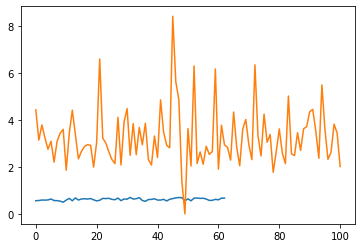

In [971]:
plt.plot(preds)
plt.plot(np.array(df[-102:-1]["Energy (kWh)"]))

## Bayesian Hyperparamter Tuning

In [973]:
import kerastuner as kt

In [974]:
def model_builder(hp):
    model = Sequential()
    mod
    for i in range(hp.Int('LSTM_layers',1,3)):
        model.add(LSTM(hp.Int(f'lstm{i}_units', min_value=10, max_value=80, step=5), return_sequences = True, activation = "tanh"))
        model.add(Dropout(hp.Float(f'lstm{i}_dropout', min_value=0, max_value=0.9, step=0.1)))
    
    for i in range(hp.Int('Dense_layers',1,3)):
        model.add(Dense(hp.Int(f'dense{i}_units', min_value=5, max_value=65, step=5), activation = "relu"))
        model.add(Dropout(hp.Float(f'dense{i}_dropout', min_value=0, max_value=0.9, step=0.1)))
    
    model.add(Dense(1))
    opt = keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=opt, loss = 'mse', metrics=['mae'])
    
    return model

In [975]:
def model_builder(hp):

    inputs = Input(shape=(None,81))
    
    x = LSTM(hp.Int('lstm0_units', min_value=20, max_value=60, step=2), return_sequences = True, activation = "tanh")(inputs)
    x = Dropout(hp.Float(f'lstm0_dropout', min_value=0, max_value=0.9, step=0.1))(x)
    
    lstm_layers = hp.Int('LSTM_layers',1,2)
    for i in range(lstm_layers):
        if i == max(range(lstm_layers)):
            x = LSTM(hp.Int(f'lstm{i + 1}_units', min_value=4, max_value=38, step=2), return_sequences = False, activation = "tanh")(x)
        else:
            x = LSTM(hp.Int(f'lstm{i + 1}_units', min_value=4, max_value=38, step=2), return_sequences = True, activation = "tanh")(x)
        x = Dropout(hp.Float(f'lstm{i + 1}_dropout', min_value=0, max_value=0.9, step=0.1))(x)
    
    for i in range(hp.Int('Dense_layers',0,3)):
        x = Dense(hp.Int(f'dense_units_{i}', min_value=1, max_value=15, step=1), activation="relu")(x)
        x = Dropout(hp.Float(f'dense{i}_dropout', min_value=0, max_value=0.9, step=0.1))(x)


    outputs = Dense(1)(x)

    m = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_model")
    
    opt = keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    m.compile(optimizer=opt, loss='mse', metrics=["mae"])

    return m

In [976]:
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_mae',
                     max_trials = 100,
                     directory='Modelling/HyperParameterTuning',
                     project_name='LSTM_small')

In [977]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

<IPython.core.display.Javascript object>

In [934]:
y_val.shape

(63, 8)

In [978]:
tuner.search(X_train_new, y_train_new, epochs=100 , batch_size=1, validation_data=(X_val_new,y_val_new), callbacks=[stop_early])


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 32 Complete [02h 52m 49s]
val_mae: 0.6668657064437866

Best val_mae So Far: 0.6231744289398193
Total elapsed time: 21h 16m 20s

Search: Running Trial #33

Hyperparameter    |Value             |Best Value So Far 
lstm0_units       |50                |58                
lstm0_dropout     |0.9               |0.9               
LSTM_layers       |1                 |1                 
lstm1_units       |38                |14                
lstm1_dropout     |0.9               |0.9               
Dense_layers      |3                 |2                 
learning_rate     |0.0001            |0.0001            
lstm2_units       |4                 |4                 
lstm2_dropout     |0                 |0.3               
dense_units_0     |1                 |1                 
dense0_dropout    |0                 |0                 
dense_units_1     |1                 |1                 
dense1_dropout    |0.9               |0                 
dense_units_2     |1                 |1  

KeyboardInterrupt: 